In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import os
from math import * 
os.getcwd()
print("The current directory is: ")
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print("Moving up to the parent directory")
print(os.getcwd())

The current directory is: 
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project\notebooks
Moving up to the parent directory
c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project


In [2]:
from stage0_configs import *
info = main_config()


Welcome to the Abaqus parameter calibration project


The configurations you have chosen: 

+------------------------+-------------+
|     Global Configs     | User choice |
+------------------------+-------------+
| Number of initial sims |      20     |
|  Initial sims spacing  |     1000    |
|   Optimize strategy    |     SOO     |
|        Material        | DP1000_room |
|     Hardening law      |    Swift    |
|        Geometry        |    NDBR50   |
|      Curve index       |      2      |
|     Optimizer name     |      BO     |
|   Deviation percent    |      5      |
+------------------------+-------------+

Generating necessary directories

The path to your main project folder is

c:\Users\springnuance\Desktop\Abaqus-Macromechanics-Project



In [15]:
targetPath = info['targetPath'] 
target = pd.read_csv(f"{targetPath}/FD_Curve.csv")
target['force/N'] = target['force/kN'] * 1000
# Save as a csv file
target.to_csv(f"{targetPath}/Force-Displacement.csv", index=False)

[0.0, 0.0300013, 0.0600055, 0.0899964, 0.119974, 0.14993, 0.179882, 0.209834, 0.239786, 0.269773, 0.299776, 0.32978, 0.359783, 0.389786, 0.41979, 0.449789, 0.479764, 0.509665, 0.539566, 0.569467, 0.599481, 0.629625, 0.659766, 0.689906, 0.720051, 0.750191, 0.780331, 0.810476, 0.840617, 0.870757, 0.900902, 0.931042, 0.961187, 0.991327, 1.02147, 1.05161, 1.08175, 1.11148, 1.14121, 1.17094, 1.20067, 1.2304, 1.26013, 1.28986, 1.31959, 1.34931, 1.37904, 1.40877, 1.4385, 1.46823, 1.49823, 1.52853, 1.55882, 1.58911, 1.61941, 1.6497, 1.68, 1.71029, 1.74058, 1.77088, 1.80117, 1.83146, 1.86176, 1.89205, 1.92234, 1.95263, 1.98293, 2.01321, 2.04308, 2.07295, 2.10281, 2.1329, 2.16291, 2.19289, 2.2228, 2.25296, 2.28268, 2.313, 2.34291, 2.3729, 2.40361, 2.43348, 2.46269, 2.49333, 2.52359, 2.55344, 2.58253, 2.61314, 2.64386, 2.67346, 2.70281, 2.73294, 2.76352, 2.79339, 2.82223, 2.85212, 2.88334, 2.91374, 2.944, 2.9728, 3.0016]
2.99976
1.4


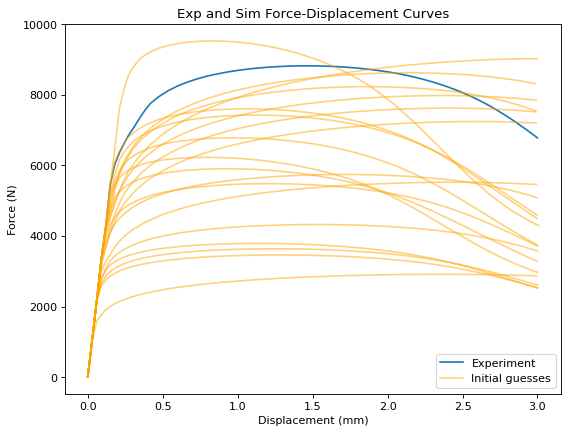

In [10]:
resultPath = info['resultPath']
initialResultPath = f"{resultPath}/initial/common"
FD_Curves = np.load(f"{initialResultPath}/FD_Curves.npy", allow_pickle=True).tolist()
print(list(FD_Curves.values())[0]['displacement'])

targetPath = info['targetPath'] 
# Load csv file
target = pd.read_csv(f"{targetPath}/FD_Curve.csv")
expForce = target['force/N'].to_numpy()
expDisplacement = target['displacement/mm'].to_numpy() 
print(max(expDisplacement))


maxDisp = ceil(1.32 * 10) / 10
print(maxDisp)
# Plotting all FD curves
figure(figsize=(8, 6), dpi=80)
plt.plot(expDisplacement, expForce, label='Experiment')
for param in FD_Curves:
    plt.plot(FD_Curves[param]['displacement'], FD_Curves[param]['force'], color='orange', alpha=0.5,
             #label=param
             )
plt.plot([],[], color='orange', alpha=0.5, label='Initial guesses')
plt.title('Exp and Sim Force-Displacement Curves')
plt.xlabel('Displacement (mm)')
plt.ylabel('Force (N)')
plt.legend()


In [2]:
# load excel file

for i in range (1, 11):
    df = pd.read_excel(f"SOO_results\DP1000_room_Swift_NDBR50_curve2/initial/{i}/parameters.xlsx")
    # Save as csv file
    df.to_csv(f"SOO_results\DP1000_room_Swift_NDBR50_curve2/initial/{i}/parameters.csv", index=False)

In [ ]:
# read npy file
FD_